# Exploring the Taste of  Neighborhoods in Toronto


## Table of Contents
1. [Introduction](#introduction)
2. [Data Sources](#Data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Clustering Neighborhoods](#cluster)
6. [Results](#results)

## 1. Introduction <a id="introduction"></a>

Toronto is the provincial capital of Ontario and the most populous city in Canada.The city is known for being the most multicultural in the world. One way to get to know the city and its people is through different ethnic foods.

In this project we will try to understand the diversity of a neighborhood by leveraging venue data from Foursquare’s ‘Places API’ and ‘k-means clustering’ machine learning algorithm. 

**Stakeholders**:
* This study would be aimed at stakeholders who are interested to use this analysis to understand the distribution of different cultures and cuisines in Toronto,this project can also be utilized by food vendors who are willing to open a new restaurant.

## 2. Data Sources <a id='Data'></a>

Based on definition of our problem the following sources will be needed for the analysis :

1. **Toronto Neighborhoods List**

    * Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
    * Description: The following page consists of a list of all the neighborhoods in a table including postcode and     borough that it belongs to.
    * **[Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)** package will be used to scrape this data from the page.
2. **Latitude and Longitude of the Neighborhoods Approximate center**
    * Link:'https://github.com/chaitanyatanga/IBM-Data-Science-Certfication/blob/master/Geospatial_Coordinates.csv'
    * Description: The following file constsisting of Latitude,Longitude,Borough and Postcode which will be combined with Neighborhoods data. 
3. **Geopy**
    * Link: https://geopy.readthedocs.io/en/stable/#
    * Desceription: geopy is a Python client for several popular geocoding web services.geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources.

3. **Foursquare API**:
    * Link: https://developer.foursquare.com/docs
    * Description: Foursquare API, a location data provider, will be used to make RESTful API calls to retrieve data about venues in different neighborhoods. This is the link to Foursquare Venue Category Hierarchy. Venues retrieved from all the neighborhoods are categorized broadly into "Arts & Entertainment", "College & University", "Event", "Food", "Nightlife Spot", "Outdoors & Recreation", etc.

    * An extract of an API call is as follows:
       
       
       {'venue': {'id': '4d669cba83865481c948fa53',
       'name': 'Images Salon & Spa',
       'location': {'address': '8130 Sheppard Ave E',
        'crossStreet': 'Morningside Ave',
        'lat': 43.80228301948931,
        'lng': -79.19856472801668,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.80228301948931,
          'lng': -79.19856472801668}],
        'distance': 595,
        'postalCode': 'M1B 3W3',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Canada',
        'formattedAddress': ['8130 Sheppard Ave E (Morningside Ave)',
         'Toronto ON M1B 3W3',
         'Canada']}}
        
        We can extract information like latitude,longitude,venue_id etc.
         

## 3. Methodology <a id='methodology' ></a>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [290]:
#Execte the below commands by removing # if importing of the packages dosen't work
#!pip install beautifulsoup4
#!pip install lxml
#!pip install geocoder
#!pip install geopy
#!pip install folium
import sys
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib as mpl
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import json
from pandas.io.json import json_normalize
from matplotlib import pyplot as plt
import reprlib
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

### Download and Data setup

#### Scraping data from the website uisng Beautiful Soup

In [291]:
#Wikipedia URL
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#using requests to get the data from the link 
source=requests.get(url).text
#Passing the response of requests methods to Beautiful soup
soup=BeautifulSoup(source,'lxml')
#selecting the table from the html using <table> class
table=soup.find('table')
#Visualising the data
#print(reprlib.repr(table.prettify()))
#if you want to view the complete output uncomment the below line
#print(table.prettify())

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data into a *pandas* dataframe.

In [292]:
#getting table headers
header_data=[]
for row in table.find_all('th'):
    header=row.text.strip()
    header_data.append(header)
print(header_data)

#getting table rows
table_data=[]
bs=BeautifulSoup(source, "lxml")
table_body=bs.find('tbody')
rows = table_body.find_all('tr')
for row in rows[1:]:
    cols=row.find_all('td')
    cols=[x.text.strip() for x in cols]
    table_data.append(cols)
#saving in a data frame
df = pd.DataFrame(table_data, columns = header_data)
df

['Postcode', 'Borough', 'Neighborhood']


,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
...,...,...,...
282,M8Z,Etobicoke,Mimico NW
283,M8Z,Etobicoke,The Queensway West
284,M8Z,Etobicoke,Royal York South West
285,M8Z,Etobicoke,South of Bloor


In [293]:
#removing boroughs that are not assigned
df=df[df['Borough']!='Not assigned']
#getting the duplicate Postcodes
df.groupby('Postcode')['Neighborhood'].nunique()

Postcode
M1B    2
M1C    3
M1E    3
M1G    1
M1H    1
      ..
M9N    1
M9P    1
M9R    4
M9V    8
M9W    1
Name: Neighborhood, Length: 103, dtype: int64

There are multiple neighborhoods with same postcode,let us combine seperated by a comma

In [294]:
#grouping with Post code and combining the neighborhoos
df=df.groupby(['Postcode','Borough'])['Neighborhood'].apply(','.join).reset_index()
df

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie..."
101,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."


There are 103 Neighborhoods in total after combining.

In order to get the venues near a neighborhood we require its coordinates.

#### Importing latitude and longitude from csv file

Download the csv file from the link provided in [Data sources](#Data) section 

In [295]:
#importing coordinates of Postal codes
latlon=pd.read_csv('Geospatial_Coordinates.csv',header=0)
latlon.head(5)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [296]:
#chaging the coloumn name to match with the 'df' data frame
latlon.rename(columns={'Postal Code':'Postcode'},inplace=True)
#merging coordinates with data frame
df=pd.merge(df,latlon, on='Postcode', how='inner')
df

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437


In [297]:
df.shape

(103, 5)

Now we have a a data frame with Neighborhoods and its coordinates.

Let us visualize these neighborhoods using [folium](https://python-visualization.github.io/folium/) centered around Toronto,In order to do that we need the coordinates of Torornto.

#### Use [geopy](#Data) library to get the latitude and longitude values of Torornto.

In [298]:
#setting address as toronto for folium map to be centered around
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="CA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Plotting neighborhoods on map using folium

In [299]:
#Generating map with centre Toronto
CA_map=folium.Map(location=[latitude,longitude],zoom_start=10)
#adding markers and labels the map  
for lat, lng, borough, neighborhood in zip(df['Latitude'], 
                                           df['Longitude'], df['Borough'],
                                           df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(CA_map)  
CA_map

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Exploring neighborhoods using foursquare API

In [300]:
#setting credentials for the API call
CLIENT_ID = 'TVR2OS3BXIAQIHPY4YQDWWG4YLLWL3EN3RPTEFIW1UP1FNJD' # your Foursquare ID
CLIENT_SECRET = '543OQ5DF0PLZETBU3H0ZPRS0KRECTHF41D2GBERMLAMFOANG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TVR2OS3BXIAQIHPY4YQDWWG4YLLWL3EN3RPTEFIW1UP1FNJD
CLIENT_SECRET:543OQ5DF0PLZETBU3H0ZPRS0KRECTHF41D2GBERMLAMFOANG


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [301]:
df.loc[0, 'Neighborhood']

'Rouge,Malvern'

Get the neighborhood's latitude and longitude values.

In [302]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge,Malvern are 43.806686299999996, -79.19435340000001.


#### Now, let's get the top 100 venues that are in this neighborhood within a radius of 1000 meters.

First, let's create the GET request URL. Name your URL **url**.

In [303]:
# type your answer here


LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

Send the GET request and examine the resutls

In [304]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e1a78566001fe001b0a03df'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 18,
  'suggestedBounds': {'ne': {'lat': 43.81568630900001,
    'lng': -79.18190576146081},
   'sw': {'lat': 43.797686290999984, 'lng': -79.20680103853921}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d669cba83865481c948fa53',
       'name': 'Images Salon & Spa',
       'location': {'address': '8130 Sheppard Ave E',
        'crossStreet': 'Morningside Ave',
        'lat': 43.80228301948931,
        'lng': -79.19856472801668,
        'labeledLatLngs'

As we can see above that all the information is in the *items* key. Before we proceed, let's create a function **get_category_type** to get the category of the venue.

In [305]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [306]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Images Salon & Spa,Spa,43.802283,-79.198565
1,Wendy's,Fast Food Restaurant,43.802008,-79.198080
2,Wendy's,Fast Food Restaurant,43.807448,-79.199056
3,Caribbean Wave,Caribbean Restaurant,43.798558,-79.195777
4,Staples Morningside,Paper / Office Supplies Store,43.800285,-79.196607


let's see how many venues were returned by Foursquare

In [307]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

18 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

<a id='item2'></a>

As we are interested in venues that belong to the food category  we have to limit our search by providing the **categoryId** in the API call

In [308]:
#food category as provided in the foursquare documentation
food_category = '4d4b7105d754a06374d81259'
#function to get the places near the neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            food_category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                    'venue id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In order to counter any redundant requests to the Foursquare API let us 

In [309]:

try:
    Toronto_venues=pd.read_csv('Toronto_venues.csv')
    print("--------Data Found and Imported--------")
except:
    print('--------Data Not found,Accesing FourSquare API--------')
    Toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    Toronto_venues.to_csv('Toronto_venues.csv',index=False)

--------Data Found and Imported--------


## 4.Analysis<a id='analysis'></a>

Let us see the data 

In [310]:
print(Toronto_venues.shape)
Toronto_venues.head()

(3763, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,579a91b3498e9bd833afa78a,Wendy's,43.802008,-79.198080,Fast Food Restaurant
1,"Rouge,Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,"Rouge,Malvern",43.806686,-79.194353,4b914562f964a520d4ae33e3,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,"Rouge,Malvern",43.806686,-79.194353,4b6718c2f964a5203f3a2be3,Harvey's,43.800106,-79.198258,Fast Food Restaurant
4,"Rouge,Malvern",43.806686,-79.194353,4c61c478edd320a1835bab29,Bella's Lechon,43.801291,-79.198378,Filipino Restaurant


Let us check the number of unique categories in the data

In [311]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 115 uniques categories.


Venue Category
Café                       301
Pizza Place                270
Restaurant                 237
Italian Restaurant         204
Bakery                     164
                          ... 
North Indian Restaurant      1
Shanghai Restaurant          1
Peking Duck Restaurant       1
Mac & Cheese Joint           1
Spanish Restaurant           1
Name: Venue Category, Length: 115, dtype: int64

In [312]:
#exploring the venues near the neighborhoods
print(Toronto_venues.shape)
Toronto_venues.head()

(3763, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,579a91b3498e9bd833afa78a,Wendy's,43.802008,-79.198080,Fast Food Restaurant
1,"Rouge,Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,"Rouge,Malvern",43.806686,-79.194353,4b914562f964a520d4ae33e3,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,"Rouge,Malvern",43.806686,-79.194353,4b6718c2f964a5203f3a2be3,Harvey's,43.800106,-79.198258,Fast Food Restaurant
4,"Rouge,Malvern",43.806686,-79.194353,4c61c478edd320a1835bab29,Bella's Lechon,43.801291,-79.198378,Filipino Restaurant


Let us find the number of unique venues 

In [313]:
Toronto_venues.groupby('Venue').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,venue id,Venue Latitude,Venue Longitude,Venue Category
Venue,,,,,,,
17 Steak House and Bar,1,1,1,1,1,1,1
2 Bros Cuisine,1,1,1,1,1,1,1
241 Pizza,5,5,5,5,5,5,5
3 Kings Café,1,1,1,1,1,1,1
5 Elements Espresso,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
سفره خانه سنتی شبستان,1,1,1,1,1,1,1
港島茶餐 Hong Kong Style Tea & Fast Food,1,1,1,1,1,1,1
銀湖燒臘 Ho Ho BBQ,1,1,1,1,1,1,1


In [314]:
#grouping by neighborhood to analyse the venues at each neighborhood
Toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100,100
Agincourt,42,42,42,42,42,42,42
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",27,27,27,27,27,27,27
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",9,9,9,9,9,9,9
"Alderwood,Long Branch",5,5,5,5,5,5,5


As we are interested in exploring the diversity of the neighborhood. Let's remove the generalized categories, like Dessert shop, Ice cream shop, etc.

In [315]:
# list all the categories
unique_categories =Toronto_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Fast Food Restaurant, Caribbean Restaurant, Filipino Restaurant, African Restaurant, Chinese Restaurant, Greek Restaurant, Bakery, Sandwich Place, BBQ Joint, Italian Restaurant, Burger Joint, Breakfast Spot, Fried Chicken Joint, Pizza Place, Mexican Restaurant, Restaurant, American Restaurant, Indian Restaurant, Hakka Restaurant, Thai Restaurant, Wings Joint, Asian Restaurant, German Restaurant, Japanese Restaurant, Diner, Cajun / Creole Restaurant, Café, Vietnamese Restaurant, Korean Restaurant, Seafood Restaurant, Middle Eastern Restaurant, Indian Chinese Restaurant, Sri Lankan Restaurant, Cantonese Restaurant, Noodle House, Malay Restaurant, Sushi Restaurant, Latin American Restaurant, Mediterranean Restaurant, Shanghai Restaurant, Hong Kong Restaurant, Dim Sum Restaurant, Taiwanese Restaurant, Deli / Bodega, Vegetarian / Vegan Restaurant, Food Court, Udon Restaurant, Hotpot Restaurant, Burrito Place, Snack Place, Cafeteria, Hot Dog Joint, Ramen Restaurant, Halal Restaurant, Steakho

In [316]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [317]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Indian Chinese Restaurant, Dim Sum Restaurant, Falafel Restaurant, Cuban Restaurant, Vegetarian / Vegan Restaurant, Persian Restaurant, Argentinian Restaurant, Hakka Restaurant, Ramen Restaurant, Modern European Restaurant, Asian Restaurant, French Restaurant, Ethiopian Restaurant, Molecular Gastronomy Restaurant, Sri Lankan Restaurant, Fried Chicken Joint, Cambodian Restaurant, Chinese Restaurant, Mediterranean Restaurant, Belgian Restaurant, Japanese Restaurant, Pakistani Restaurant, New American Restaurant, Israeli Restaurant, Noodle House, Cantonese Restaurant, Colombian Restaurant, Burrito Place, Souvlaki Shop, Afghan Restaurant, Tapas Restaurant, Indian Restaurant, Middle Eastern Restaurant, Pide Place, Caribbean Restaurant, Turkish Restaurant, Italian Restaurant, Sushi Restaurant, Jewish Restaurant, Latin American Restaurant, Southern / Soul Food Restaurant, Greek Restaurant, Thai Restaurant, Arepa Restaurant, Polish Restaurant, Steakhouse, Tibetan Restaurant, Japanese Curry Res

In [318]:
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,579a91b3498e9bd833afa78a,Wendy's,43.802008,-79.198080,Fast Food Restaurant
1,"Rouge,Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,"Rouge,Malvern",43.806686,-79.194353,4b914562f964a520d4ae33e3,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,"Rouge,Malvern",43.806686,-79.194353,4b6718c2f964a5203f3a2be3,Harvey's,43.800106,-79.198258,Fast Food Restaurant
4,"Rouge,Malvern",43.806686,-79.194353,4c61c478edd320a1835bab29,Bella's Lechon,43.801291,-79.198378,Filipino Restaurant


Let's remove all the generalized categories, like Coffee Shop, Cafe, etc.

In [319]:
Toronto_venues = Toronto_venues[Toronto_venues['Venue Category'].isin(food_categories)].reset_index()
Toronto_venues.drop(columns=['index'],inplace=True)
print(Toronto_venues.shape)
Toronto_venues.head(5)

(2277, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,579a91b3498e9bd833afa78a,Wendy's,43.802008,-79.198080,Fast Food Restaurant
1,"Rouge,Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,"Rouge,Malvern",43.806686,-79.194353,4b914562f964a520d4ae33e3,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,"Rouge,Malvern",43.806686,-79.194353,4b6718c2f964a5203f3a2be3,Harvey's,43.800106,-79.198258,Fast Food Restaurant
4,"Rouge,Malvern",43.806686,-79.194353,4c61c478edd320a1835bab29,Bella's Lechon,43.801291,-79.198378,Filipino Restaurant


In [320]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 84 uniques categories.


In [321]:
print('There are {} uniques venues.'.format(len(Toronto_venues['Venue'].unique())))

There are 1267 uniques venues.


In [322]:
#checking for venue categories with neighborhood
#df_nyc_venues[df_nyc_venues['Venue Category']=='Neighborhood']

Let's see the top 10 food categories in Torornto,first we will group the venues based on category

In [323]:
Toronto_top_venues=Toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Let us Visualize this in the form of a horizantal bar chart

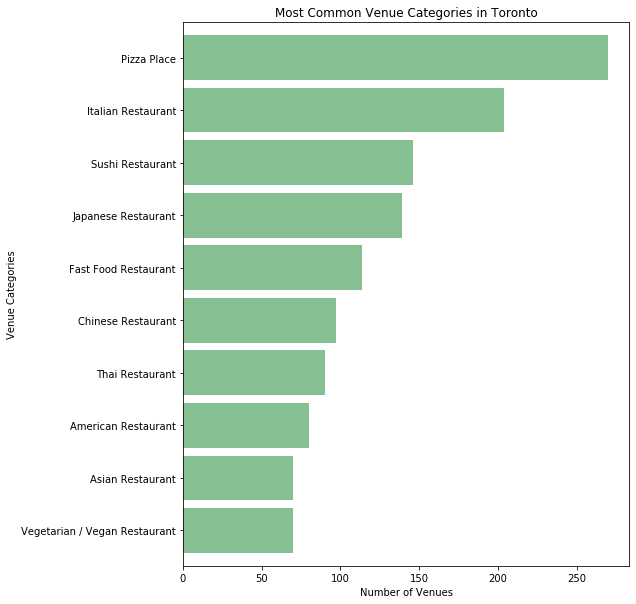

In [324]:
ax=Toronto_top_venues.head(10).plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)
ax.set_title('Most Common Venue Categories in Toronto')
ax.set_ylabel('Venue Categories')
ax.set_xlabel('Number of Venues')
ax.invert_yaxis()
plt.show()

### Analyze Each Neighborhood

In [325]:
# one hot encoding for Venue categories
Toronto_onehot= pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot.insert(0,'Neighborhood',Toronto_venues['Neighborhood'])
Toronto_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [326]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Adelaide,King,Richmond",0.0,0.0,0.050000,0.0,0.0,0.050000,0.000000,0.0,0.016667,...,0.016667,0.0,0.016667,0.0,0.033333,0.0,0.0,0.000000,0.050000,0.000000
1,Agincourt,0.0,0.0,0.029412,0.0,0.0,0.058824,0.029412,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.029412
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.000000,0.0,0.0,0.000000,0.083333,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.041667,0.041667,0.000000
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,"Alderwood,Long Branch",0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [327]:
Toronto_grouped.shape

(100, 85)

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [328]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [329]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Japanese Restaurant,Italian Restaurant,Pizza Place,Steakhouse,Sushi Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,American Restaurant,Ramen Restaurant
1,Agincourt,Chinese Restaurant,Pizza Place,Asian Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Indian Restaurant,Noodle House,Mediterranean Restaurant,Malay Restaurant,Latin American Restaurant
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Pizza Place,Fast Food Restaurant,Noodle House,Korean Restaurant,BBQ Joint,Malay Restaurant,Fried Chicken Joint,Caribbean Restaurant,Japanese Restaurant
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Fried Chicken Joint,Caribbean Restaurant,Japanese Restaurant,Sushi Restaurant,Indian Chinese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
4,"Alderwood,Long Branch",Pizza Place,Moroccan Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
95,Willowdale West,Pizza Place,Sushi Restaurant,Eastern European Restaurant,Indonesian Restaurant,Fried Chicken Joint,Israeli Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
96,Woburn,Pizza Place,American Restaurant,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,German Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant
97,"Woodbine Gardens,Parkview Hill",Pizza Place,Fast Food Restaurant,Vietnamese Restaurant,German Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
98,Woodbine Heights,Pizza Place,Thai Restaurant,Greek Restaurant,Asian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant


#### Now we will visualize the most common venues for each neighborhood using folium

First lets add latitude and longitude data from the original dataframe 'df' to 'Torornto_grouped'

In [330]:
#create a copy of venues data
x_toronto=df.copy()
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
x_toronto= x_toronto.join(Toronto_grouped.set_index('Neighborhood'), on='Neighborhood')

Lets look at the data frame

In [331]:
#x_toronto.head()
x_toronto.shape

(103, 89)

Now let us find the most common venue in each neighhood and create a dataframe 

we will use idmxmax function to get a list of most common venue categories 

In [332]:
#we dont need the columns from 0-7
y_toronto=x_toronto.iloc[:,8:435].idxmax(axis=1)

In [333]:
y_toronto

0      Fast Food Restaurant
1        Italian Restaurant
2               Pizza Place
3        Chinese Restaurant
4        Chinese Restaurant
               ...         
98              Pizza Place
99              Pizza Place
100      Chinese Restaurant
101             Pizza Place
102                     NaN
Length: 103, dtype: object

In [334]:
#add a new column and link the neighborhood names back
y_toronto=pd.DataFrame(y_toronto,columns=['Venue Category'])
y_toronto.insert(0,'Neighborhood',x_toronto['Neighborhood'])
y_toronto[['Latitude','Longitude']]=x_toronto[['Latitude','Longitude']]
y_toronto

,Neighborhood,Venue Category,Latitude,Longitude
0,"Rouge,Malvern",Fast Food Restaurant,43.806686,-79.194353
1,"Highland Creek,Rouge Hill,Port Union",Italian Restaurant,43.784535,-79.160497
2,"Guildwood,Morningside,West Hill",Pizza Place,43.763573,-79.188711
3,Woburn,Chinese Restaurant,43.770992,-79.216917
4,Cedarbrae,Chinese Restaurant,43.773136,-79.239476
...,...,...,...,...
98,Weston,Pizza Place,43.706876,-79.518188
99,Westmount,Pizza Place,43.696319,-79.532242
100,"Kingsview Village,Martin Grove Gardens,Richvie...",Chinese Restaurant,43.688905,-79.554724
101,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,43.739416,-79.588437


Lets crete a map with markers displaying this information

In [335]:
map_2 = folium.Map(location=[latitude,longitude],zoom_start=10)

# add markers to map
for lat, lng, venue,neighborhood in zip(y_toronto['Latitude'], y_toronto['Longitude'],y_toronto['Venue Category'],y_toronto['Neighborhood']):
    label = '{},{}'.format(venue,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_2)
    
map_2

## 5. Clustering Neighborhoods <a id='cluster'></a>

Run k-means to count Neighborhoods for each cluster label for variable cluster size

In [336]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

Determine the optimal number of clusters for k-means clustering

The Elbow Method - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [337]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

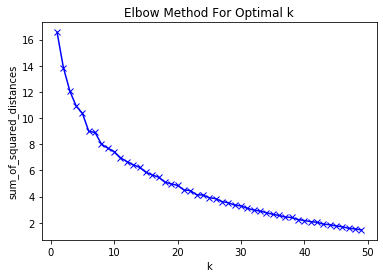

In [338]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

The Silhouette Method - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [339]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(Toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

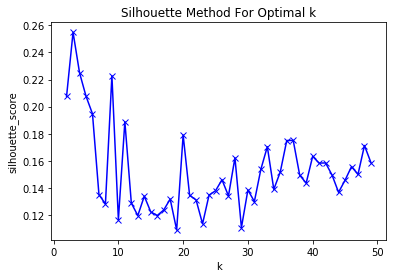

In [340]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at k = 2, k = 5 and k = 8. Two and four clusters will give a very broad classification of the venues.

#### Let's set number of clusters = 8

In [341]:
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(Toronto_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({3: 55, 0: 16, 5: 11, 4: 10, 7: 3, 1: 2, 2: 2, 6: 1})


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [342]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [343]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,"Adelaide,King,Richmond",Japanese Restaurant,Italian Restaurant,Pizza Place,Steakhouse,Sushi Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,American Restaurant,Ramen Restaurant
1,5,Agincourt,Chinese Restaurant,Pizza Place,Asian Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Indian Restaurant,Noodle House,Mediterranean Restaurant,Malay Restaurant,Latin American Restaurant
2,5,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Pizza Place,Fast Food Restaurant,Noodle House,Korean Restaurant,BBQ Joint,Malay Restaurant,Fried Chicken Joint,Caribbean Restaurant,Japanese Restaurant
3,4,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Fried Chicken Joint,Caribbean Restaurant,Japanese Restaurant,Sushi Restaurant,Indian Chinese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
4,4,"Alderwood,Long Branch",Pizza Place,Moroccan Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant


In [344]:
# merge neighborhoods_venues_sorted with df to add latitude/longitude for each neighborhood
Toronto_merged = neighborhoods_venues_sorted.join(df.set_index('Neighborhood'), on='Neighborhood')


Finally, let's visualize the resulting clusters

In [345]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6.Results <a id='results'></a>

Lets analyse each clusters 1st,3rd and 5th most common venues to understand the nature of the cluster

In [346]:
required_column_indices = [2,4,6]
required_column = [list(Toronto_merged.columns.values)[i] for i in required_column_indices]

#### cluster 0

In [347]:
cluster_0=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(2, Toronto_merged.shape[1]-4))]]

In [348]:
cluster_0.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Bathurst Manor,Downsview North,Wilson Heights",Pizza Place,Mediterranean Restaurant,Chinese Restaurant,Fried Chicken Joint,Middle Eastern Restaurant,Sushi Restaurant,Hawaiian Restaurant,French Restaurant,Empanada Restaurant,Ethiopian Restaurant
31,"Del Ray,Keelesdale,Mount Dennis,Silverthorn",Italian Restaurant,Pizza Place,German Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
47,Glencairn,Italian Restaurant,Pizza Place,Asian Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Japanese Restaurant,Latin American Restaurant,Sushi Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant
57,Humber Summit,Pizza Place,Italian Restaurant,Empanada Restaurant,German Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
58,Humewood-Cedarvale,Pizza Place,Sushi Restaurant,Italian Restaurant,Israeli Restaurant,Korean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Fried Chicken Joint,Ethiopian Restaurant


In [349]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place                  12
Italian Restaurant            3
Middle Eastern Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Sushi Restaurant               3
Japanese Restaurant            2
Portuguese Restaurant          1
Chinese Restaurant             1
Eastern European Restaurant    1
Fast Food Restaurant           1
Indian Restaurant              1
Greek Restaurant               1
Indian Chinese Restaurant      1
Asian Restaurant               1
Italian Restaurant             1
Empanada Restaurant            1
German Restaurant              1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
Ethiopian Restaurant           2
Mexican Restaurant             1
Mediterranean Restaurant       1
Caribbean Restaurant           1
Fried Chicken Joint            1
Falafel Restaurant             1
Thai Restaurant                1
Middle Eastern Restaurant      1
BBQ Joint                      1
Ko

#### cluster 1

In [350]:
cluster_1=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(2, Toronto_merged.shape[1]-4))]]


In [351]:
cluster_1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Downsview Central,Vietnamese Restaurant,Greek Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant
38,Downsview West,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,German Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint


In [352]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Vietnamese Restaurant    2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Empanada Restaurant    1
Chinese Restaurant     1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
Ethiopian Restaurant    1
Falafel Restaurant      1
Name: 5th Most Common Venue, dtype: int64
---------------------------------------------


#### cluster 2

In [353]:
cluster_2=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(2, Toronto_merged.shape[1]-4))]]


In [354]:
cluster_2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,"Emery,Humberlea",Italian Restaurant,Vietnamese Restaurant,Greek Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
53,"Highland Creek,Rouge Hill,Port Union",Italian Restaurant,Vietnamese Restaurant,Greek Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint


In [355]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Greek Restaurant    2
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
Ethiopian Restaurant    2
Name: 5th Most Common Venue, dtype: int64
---------------------------------------------


#### cluster 3

In [356]:
cluster_3=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(2, Toronto_merged.shape[1]-4))]]


In [357]:
cluster_3.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Japanese Restaurant,Italian Restaurant,Pizza Place,Steakhouse,Sushi Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,American Restaurant,Ramen Restaurant
6,Bayview Village,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant
7,"Bedford Park,Lawrence Manor East",Pizza Place,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Thai Restaurant,Greek Restaurant,Japanese Restaurant,Indian Restaurant,American Restaurant,Hong Kong Restaurant
8,Berczy Park,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,American Restaurant,Steakhouse,BBQ Joint,Vegetarian / Vegan Restaurant,New American Restaurant,Pizza Place,Belgian Restaurant
11,"Brockton,Exhibition Place,Parkdale Village",Pizza Place,Japanese Restaurant,Poutine Place,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Burrito Place,Indian Restaurant,Korean Restaurant,Italian Restaurant,French Restaurant


In [358]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant               15
Japanese Restaurant               9
Pizza Place                       8
Fast Food Restaurant              4
Sushi Restaurant                  4
Indian Restaurant                 3
Vegetarian / Vegan Restaurant     2
Greek Restaurant                  2
Korean Restaurant                 2
Mexican Restaurant                1
Chinese Restaurant                1
Thai Restaurant                   1
Burrito Place                     1
Vietnamese Restaurant             1
Turkish Restaurant                1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Sushi Restaurant                 7
Pizza Place                      5
Asian Restaurant                 5
Indian Restaurant                4
Seafood Restaurant               4
Chinese Restaurant               3
Fast Food Restaurant             3
Vietnamese Restaurant            3
Thai Restaurant                  2
Latin American Restaurant        2
Japanese Restaurant   

#### cluster 4

In [359]:
cluster_4=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(2, Toronto_merged.shape[1]-4))]]


In [360]:
cluster_4.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Fried Chicken Joint,Caribbean Restaurant,Japanese Restaurant,Sushi Restaurant,Indian Chinese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
4,"Alderwood,Long Branch",Pizza Place,Moroccan Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant
10,"Bloordale Gardens,Eringate,Markland Wood,Old B...",Pizza Place,Vietnamese Restaurant,German Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
23,"Clairlea,Golden Mile,Oakridge",Pizza Place,Mexican Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
25,"Cliffcrest,Cliffside,Scarborough Village West",Pizza Place,Cajun / Creole Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant


In [361]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place            9
Japanese Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Vietnamese Restaurant        3
German Restaurant            2
Mexican Restaurant           1
Caribbean Restaurant         1
Fried Chicken Joint          1
Middle Eastern Restaurant    1
Fast Food Restaurant         1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
Ethiopian Restaurant    3
Falafel Restaurant      2
Greek Restaurant        2
Mexican Restaurant      1
Sushi Restaurant        1
German Restaurant       1
Name: 5th Most Common Venue, dtype: int64
---------------------------------------------


#### cluster 5

In [362]:
cluster_5=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[[1] + list(range(2, Toronto_merged.shape[1]-4))]]


In [363]:
cluster_5.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Agincourt,Chinese Restaurant,Pizza Place,Asian Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Indian Restaurant,Noodle House,Mediterranean Restaurant,Malay Restaurant,Latin American Restaurant
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Pizza Place,Fast Food Restaurant,Noodle House,Korean Restaurant,BBQ Joint,Malay Restaurant,Fried Chicken Joint,Caribbean Restaurant,Japanese Restaurant
37,Downsview Northwest,Pizza Place,Fried Chicken Joint,Falafel Restaurant,Fast Food Restaurant,Chinese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,American Restaurant,Hong Kong Restaurant,Hawaiian Restaurant
39,"Downsview,North Park,Upwood Park",Pizza Place,Dim Sum Restaurant,Mediterranean Restaurant,Chinese Restaurant,German Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
40,"East Birchmount Park,Ionview,Kennedy Park",Chinese Restaurant,Pizza Place,Fast Food Restaurant,Asian Restaurant,Vietnamese Restaurant,German Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant


In [364]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place           7
Chinese Restaurant    4
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant        3
Chinese Restaurant          2
Mediterranean Restaurant    1
Falafel Restaurant          1
French Restaurant           1
Japanese Restaurant         1
Asian Restaurant            1
Indian Restaurant           1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
Vietnamese Restaurant    4
German Restaurant        3
Chinese Restaurant       2
Korean Restaurant        1
Indian Restaurant        1
Name: 5th Most Common Venue, dtype: int64
---------------------------------------------


#### cluster 6

In [365]:
cluster_6=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 6, Toronto_merged.columns[[1] + list(range(2, Toronto_merged.shape[1]-4))]]


In [366]:
cluster_6.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Birch Cliff,Cliffside West",Thai Restaurant,Vietnamese Restaurant,Greek Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint


In [367]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Thai Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Greek Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
Ethiopian Restaurant    1
Name: 5th Most Common Venue, dtype: int64
---------------------------------------------


#### cluster 7

In [368]:
cluster_7=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 7, Toronto_merged.columns[[1] + list(range(2, Toronto_merged.shape[1]-4))]]


In [369]:
cluster_7.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Lawrence Park,Sushi Restaurant,Pizza Place,Fast Food Restaurant,Dumpling Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
71,Not assigned,Pizza Place,Fast Food Restaurant,Vietnamese Restaurant,German Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
97,"Woodbine Gardens,Parkview Hill",Pizza Place,Fast Food Restaurant,Vietnamese Restaurant,German Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint


In [370]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place         2
Sushi Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Vietnamese Restaurant    2
Fast Food Restaurant     1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
Empanada Restaurant    3
Name: 5th Most Common Venue, dtype: int64
---------------------------------------------


### Conclusion

We clustered the neighborhoods based on the most common food venues in the neighborhoods in to 8 clusters,this analysis 

### Thank You
* References: Notebook created by **Alex Aklson** for the course on Coursera called Applied Data Science Capstone